In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset,ConcatDataset

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import os

# import cv2
import torchvision
import copy
import tqdm
from PIL import Image
import zipfile

In [2]:
lr =0.001
batch_size=100
epochs = 10

device="cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(1234)
if device == 'cuda':
    torch.cuda.manual_seed_all(1234)

# Load train and test data
train_dir = '/Users/peterstroessler/Documents/Projects/cats_and_dogs/catdog/train'
test_dir = '/Users/peterstroessler/Documents/Projects/cats_and_dogs/catdog/test'
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

random_idx = np.random.randint(1,25000,size=10)

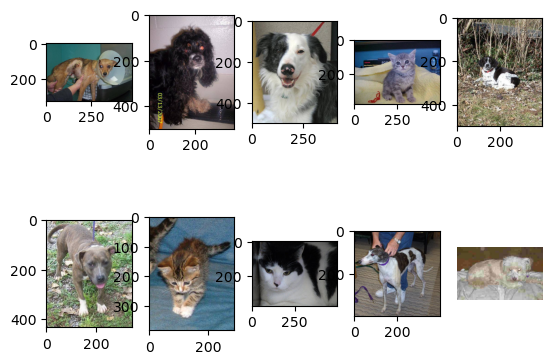

In [3]:
fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [4]:
train_transforms =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    
    
])

val_transforms  =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    
    
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    
    
])

In [5]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform = None):
        self.file_list=file_list
        self.transform=transform
    
    def __len__(self):
        self.filelength =len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path =self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
        
        return img_transformed,label
    

In [6]:
from sklearn.model_selection import train_test_split
train_list,val_list = train_test_split(train_list , test_size =0.2)
train_data = dataset(train_list,transform=train_transforms)
test_data = dataset(test_list,transform=test_transforms)
val_data = dataset(val_list,transform=test_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = batch_size,shuffle = True)
print(len(train_data),len(train_loader))
print(len(val_data), len(val_loader))

20000 200
5000 50


In [7]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [8]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
         
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out =self.layer1(x)
        out =self.layer2(out)
        out =self.layer3(out)
        out =out.view(out.size(0),-1)
        out =self.relu(self.fc1(out))
        out =self.fc2(out)
        return out
    

model = Cnn().to(device)
model.train()
optimizer = optim.Adam(params = model.parameters(),lr =0.001)
criterion = nn.CrossEntropyLoss()

In [9]:
epochs = 10

for epoch in range(epochs):
 
    epoch_loss =0
    epoch_accuracy = 0
    for data,label in train_loader:
        data= data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1)==label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
    with torch.no_grad():
        epoch_val_accuracy =0
        epoch_val_loss = 0
        for data,label in  val_loader:
            data= data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(output,label)


            acc = ((output.argmax(dim=1)==label).float().mean())
            epoch_val_accuracy += acc/len(val_loader)
            epoch_val_loss += val_loss/len(val_loader)
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


dog_probs = []
model.eval()

Epoch : 1, train accuracy : 0.0022499999031424522, train loss : 0.0034716976806521416
Epoch : 1, train accuracy : 0.005249999929219484, train loss : 0.00688051525503397
Epoch : 1, train accuracy : 0.008100000210106373, train loss : 0.010300662368535995
Epoch : 1, train accuracy : 0.011099999770522118, train loss : 0.013659088872373104
Epoch : 1, train accuracy : 0.014349999837577343, train loss : 0.01699916459619999
Epoch : 1, train accuracy : 0.017099998891353607, train loss : 0.020418917760252953
Epoch : 1, train accuracy : 0.02044999971985817, train loss : 0.023680521175265312
Epoch : 1, train accuracy : 0.023399999365210533, train loss : 0.02703268453478813
Epoch : 1, train accuracy : 0.026349999010562897, train loss : 0.0303921140730381
Epoch : 1, train accuracy : 0.02944999933242798, train loss : 0.033711258322000504
Epoch : 1, train accuracy : 0.03229999914765358, train loss : 0.036951690912246704
Epoch : 1, train accuracy : 0.035349998623132706, train loss : 0.04021625965833664

Epoch : 1, train accuracy : 0.31544992327690125, train loss : 0.33052074909210205
Epoch : 1, train accuracy : 0.318899929523468, train loss : 0.33348822593688965
Epoch : 1, train accuracy : 0.3219999372959137, train loss : 0.3366367220878601
Epoch : 1, train accuracy : 0.325499951839447, train loss : 0.33959832787513733
Epoch : 1, train accuracy : 0.32854995131492615, train loss : 0.3429999351501465
Epoch : 1, train accuracy : 0.3317999541759491, train loss : 0.34608128666877747
Epoch : 1, train accuracy : 0.3348499536514282, train loss : 0.3491908311843872
Epoch : 1, train accuracy : 0.3386499583721161, train loss : 0.3518874943256378
Epoch : 1, train accuracy : 0.34189996123313904, train loss : 0.35484588146209717
Epoch : 1, train accuracy : 0.34544995427131653, train loss : 0.35787883400917053
Epoch : 1, train accuracy : 0.3481999635696411, train loss : 0.36112043261528015
Epoch : 1, train accuracy : 0.351999968290329, train loss : 0.3637637794017792
Epoch : 1, train accuracy : 0.35

Epoch : 1, val_accuracy : 0.04779999703168869, val_loss : 0.08355382084846497
Epoch : 1, val_accuracy : 0.057999998331069946, val_loss : 0.09978944063186646
Epoch : 1, val_accuracy : 0.0681999996304512, val_loss : 0.11704143136739731
Epoch : 1, val_accuracy : 0.07840000092983246, val_loss : 0.13221342861652374
Epoch : 1, val_accuracy : 0.08959999680519104, val_loss : 0.14731110632419586
Epoch : 1, val_accuracy : 0.09959999471902847, val_loss : 0.16434846818447113
Epoch : 1, val_accuracy : 0.11039999127388, val_loss : 0.18054838478565216
Epoch : 1, val_accuracy : 0.11959999054670334, val_loss : 0.19726267457008362
Epoch : 1, val_accuracy : 0.13079999387264252, val_loss : 0.2134065330028534
Epoch : 1, val_accuracy : 0.1403999924659729, val_loss : 0.2300529032945633
Epoch : 1, val_accuracy : 0.14819999039173126, val_loss : 0.24783320724964142
Epoch : 1, val_accuracy : 0.15699999034404755, val_loss : 0.2652643918991089
Epoch : 1, val_accuracy : 0.1671999841928482, val_loss : 0.280623853206

Epoch : 2, train accuracy : 0.2018500417470932, train loss : 0.16843226552009583
Epoch : 2, train accuracy : 0.20555004477500916, train loss : 0.1710512936115265
Epoch : 2, train accuracy : 0.20865003764629364, train loss : 0.17410153150558472
Epoch : 2, train accuracy : 0.2119000405073166, train loss : 0.17729541659355164
Epoch : 2, train accuracy : 0.2153000384569168, train loss : 0.18032214045524597
Epoch : 2, train accuracy : 0.21860003471374512, train loss : 0.18329137563705444
Epoch : 2, train accuracy : 0.22195003926753998, train loss : 0.18625177443027496
Epoch : 2, train accuracy : 0.22540004551410675, train loss : 0.18912677466869354
Epoch : 2, train accuracy : 0.22895003855228424, train loss : 0.1919993758201599
Epoch : 2, train accuracy : 0.2323000431060791, train loss : 0.19503404200077057
Epoch : 2, train accuracy : 0.23580004274845123, train loss : 0.19795694947242737
Epoch : 2, train accuracy : 0.2395000457763672, train loss : 0.20067675411701202
Epoch : 2, train accura

Epoch : 2, train accuracy : 0.5513501167297363, train loss : 0.4672583043575287
Epoch : 2, train accuracy : 0.5548000931739807, train loss : 0.4701427221298218
Epoch : 2, train accuracy : 0.5582001209259033, train loss : 0.4725845158100128
Epoch : 2, train accuracy : 0.5617001056671143, train loss : 0.4754678010940552
Epoch : 2, train accuracy : 0.5650001168251038, train loss : 0.47865134477615356
Epoch : 2, train accuracy : 0.5686501264572144, train loss : 0.4815826714038849
Epoch : 2, train accuracy : 0.572650134563446, train loss : 0.4840514659881592
Epoch : 2, train accuracy : 0.5763501524925232, train loss : 0.48688462376594543
Epoch : 2, train accuracy : 0.5800501704216003, train loss : 0.48954087495803833
Epoch : 2, train accuracy : 0.5835001468658447, train loss : 0.4922594130039215
Epoch : 2, train accuracy : 0.5866501331329346, train loss : 0.4954785108566284
Epoch : 2, train accuracy : 0.5899001359939575, train loss : 0.49857303500175476
Epoch : 2, train accuracy : 0.5933501

Epoch : 3, train accuracy : 0.049949999898672104, train loss : 0.039203476160764694
Epoch : 3, train accuracy : 0.053950000554323196, train loss : 0.04154910519719124
Epoch : 3, train accuracy : 0.05755000188946724, train loss : 0.04437887296080589
Epoch : 3, train accuracy : 0.06160000339150429, train loss : 0.04680062457919121
Epoch : 3, train accuracy : 0.06495000422000885, train loss : 0.05010707303881645
Epoch : 3, train accuracy : 0.06850000470876694, train loss : 0.05262986570596695
Epoch : 3, train accuracy : 0.0723000019788742, train loss : 0.055281758308410645
Epoch : 3, train accuracy : 0.07590000331401825, train loss : 0.058277443051338196
Epoch : 3, train accuracy : 0.07980000227689743, train loss : 0.06086541339755058
Epoch : 3, train accuracy : 0.08354999870061874, train loss : 0.06361342966556549
Epoch : 3, train accuracy : 0.08704999834299088, train loss : 0.06661803275346756
Epoch : 3, train accuracy : 0.090549997985363, train loss : 0.06928607076406479
Epoch : 3, tra

Epoch : 3, train accuracy : 0.41055014729499817, train loss : 0.3223588764667511
Epoch : 3, train accuracy : 0.4143001437187195, train loss : 0.32482215762138367
Epoch : 3, train accuracy : 0.4182501435279846, train loss : 0.32738083600997925
Epoch : 3, train accuracy : 0.4221501350402832, train loss : 0.3300400376319885
Epoch : 3, train accuracy : 0.4257001280784607, train loss : 0.33302828669548035
Epoch : 3, train accuracy : 0.4293501377105713, train loss : 0.33575230836868286
Epoch : 3, train accuracy : 0.43260014057159424, train loss : 0.3387625217437744
Epoch : 3, train accuracy : 0.43615013360977173, train loss : 0.3415887951850891
Epoch : 3, train accuracy : 0.4396001398563385, train loss : 0.3446348309516907
Epoch : 3, train accuracy : 0.4430001378059387, train loss : 0.3475256860256195
Epoch : 3, train accuracy : 0.44650015234947205, train loss : 0.3503747582435608
Epoch : 3, train accuracy : 0.45025014877319336, train loss : 0.35307833552360535
Epoch : 3, train accuracy : 0.

Epoch : 3, val_accuracy : 0.19220000505447388, val_loss : 0.34167560935020447
Epoch : 3, val_accuracy : 0.20059999823570251, val_loss : 0.36143097281455994
Epoch : 3, val_accuracy : 0.21220000088214874, val_loss : 0.3784988820552826
Epoch : 3, val_accuracy : 0.2215999960899353, val_loss : 0.39879029989242554
Epoch : 3, val_accuracy : 0.2313999980688095, val_loss : 0.41745421290397644
Epoch : 3, val_accuracy : 0.24079999327659607, val_loss : 0.43627652525901794
Epoch : 3, val_accuracy : 0.2491999864578247, val_loss : 0.4575640857219696
Epoch : 3, val_accuracy : 0.2587999999523163, val_loss : 0.4757169187068939
Epoch : 3, val_accuracy : 0.26840001344680786, val_loss : 0.49470677971839905
Epoch : 3, val_accuracy : 0.2782000005245209, val_loss : 0.5122512578964233
Epoch : 3, val_accuracy : 0.28780001401901245, val_loss : 0.531039834022522
Epoch : 3, val_accuracy : 0.2988000214099884, val_loss : 0.5469450354576111
Epoch : 3, val_accuracy : 0.30880001187324524, val_loss : 0.5653201341629028


Epoch : 4, train accuracy : 0.26144999265670776, train loss : 0.19244225323200226
Epoch : 4, train accuracy : 0.2650499939918518, train loss : 0.1947631686925888
Epoch : 4, train accuracy : 0.26864999532699585, train loss : 0.19728316366672516
Epoch : 4, train accuracy : 0.2724500000476837, train loss : 0.19964134693145752
Epoch : 4, train accuracy : 0.2761000096797943, train loss : 0.2023424208164215
Epoch : 4, train accuracy : 0.27950000762939453, train loss : 0.20524927973747253
Epoch : 4, train accuracy : 0.28335002064704895, train loss : 0.20785483717918396
Epoch : 4, train accuracy : 0.2868000268936157, train loss : 0.21049323678016663
Epoch : 4, train accuracy : 0.2901500165462494, train loss : 0.21349789202213287
Epoch : 4, train accuracy : 0.29385000467300415, train loss : 0.21636341512203217
Epoch : 4, train accuracy : 0.29770001769065857, train loss : 0.21870233118534088
Epoch : 4, train accuracy : 0.30125001072883606, train loss : 0.22140918672084808
Epoch : 4, train accura

Epoch : 4, train accuracy : 0.6388502717018127, train loss : 0.45820382237434387
Epoch : 4, train accuracy : 0.6425002813339233, train loss : 0.460740327835083
Epoch : 4, train accuracy : 0.6460002660751343, train loss : 0.4634290933609009
Epoch : 4, train accuracy : 0.6496002674102783, train loss : 0.46604469418525696
Epoch : 4, train accuracy : 0.6532502770423889, train loss : 0.46899911761283875
Epoch : 4, train accuracy : 0.657100260257721, train loss : 0.4713187515735626
Epoch : 4, train accuracy : 0.6611002683639526, train loss : 0.4736064672470093
Epoch : 4, train accuracy : 0.6647502779960632, train loss : 0.4762881100177765
Epoch : 4, train accuracy : 0.6685003042221069, train loss : 0.4787747859954834
Epoch : 4, train accuracy : 0.6719502806663513, train loss : 0.48152855038642883
Epoch : 4, train accuracy : 0.6755002737045288, train loss : 0.4844856560230255
Epoch : 4, train accuracy : 0.6793502569198608, train loss : 0.48689496517181396
Epoch : 4, train accuracy : 0.6833002

Epoch : 5, train accuracy : 0.10229998826980591, train loss : 0.07512177526950836
Epoch : 5, train accuracy : 0.10624998807907104, train loss : 0.07738058269023895
Epoch : 5, train accuracy : 0.11009998619556427, train loss : 0.07979467511177063
Epoch : 5, train accuracy : 0.1139499843120575, train loss : 0.0822381004691124
Epoch : 5, train accuracy : 0.11754998564720154, train loss : 0.0849790945649147
Epoch : 5, train accuracy : 0.12149998545646667, train loss : 0.08749094605445862
Epoch : 5, train accuracy : 0.12504997849464417, train loss : 0.09001234173774719
Epoch : 5, train accuracy : 0.12859997153282166, train loss : 0.09253471344709396
Epoch : 5, train accuracy : 0.13224996626377106, train loss : 0.0953289121389389
Epoch : 5, train accuracy : 0.13609996438026428, train loss : 0.09788250923156738
Epoch : 5, train accuracy : 0.13969996571540833, train loss : 0.10050031542778015
Epoch : 5, train accuracy : 0.14334996044635773, train loss : 0.1031428873538971
Epoch : 5, train accu

Epoch : 5, train accuracy : 0.4871000647544861, train loss : 0.32637932896614075
Epoch : 5, train accuracy : 0.49100005626678467, train loss : 0.32886776328086853
Epoch : 5, train accuracy : 0.49465006589889526, train loss : 0.3314730226993561
Epoch : 5, train accuracy : 0.4981500804424286, train loss : 0.3340834975242615
Epoch : 5, train accuracy : 0.5018000602722168, train loss : 0.33644354343414307
Epoch : 5, train accuracy : 0.505500078201294, train loss : 0.33896416425704956
Epoch : 5, train accuracy : 0.509350061416626, train loss : 0.34138718247413635
Epoch : 5, train accuracy : 0.5130000710487366, train loss : 0.3441488444805145
Epoch : 5, train accuracy : 0.5166000723838806, train loss : 0.34670883417129517
Epoch : 5, train accuracy : 0.5202500820159912, train loss : 0.3492497503757477
Epoch : 5, train accuracy : 0.524350106716156, train loss : 0.35158678889274597
Epoch : 5, train accuracy : 0.5283501148223877, train loss : 0.3540278673171997
Epoch : 5, train accuracy : 0.5320

Epoch : 5, val_accuracy : 0.31539997458457947, val_loss : 0.6430599689483643
Epoch : 5, val_accuracy : 0.3243999779224396, val_loss : 0.6638211011886597
Epoch : 5, val_accuracy : 0.3349999785423279, val_loss : 0.6822082996368408
Epoch : 5, val_accuracy : 0.34539997577667236, val_loss : 0.7000441551208496
Epoch : 5, val_accuracy : 0.35579997301101685, val_loss : 0.7188659906387329
Epoch : 5, val_accuracy : 0.3653999865055084, val_loss : 0.7405109405517578
Epoch : 5, val_accuracy : 0.375, val_loss : 0.7593241930007935
Epoch : 5, val_accuracy : 0.38359999656677246, val_loss : 0.7804322838783264
Epoch : 5, val_accuracy : 0.3917999863624573, val_loss : 0.8014206290245056
Epoch : 5, val_accuracy : 0.4027999937534332, val_loss : 0.8196552395820618
Epoch : 5, val_accuracy : 0.41119998693466187, val_loss : 0.842445433139801
Epoch : 5, val_accuracy : 0.4213999807834625, val_loss : 0.8606236577033997
Epoch : 5, val_accuracy : 0.4327999949455261, val_loss : 0.8799569606781006
Epoch : 5, val_accura

Epoch : 6, train accuracy : 0.3186999261379242, train loss : 0.2140052318572998
Epoch : 6, train accuracy : 0.3224499225616455, train loss : 0.2163430154323578
Epoch : 6, train accuracy : 0.32604992389678955, train loss : 0.2189120203256607
Epoch : 6, train accuracy : 0.32989993691444397, train loss : 0.22111962735652924
Epoch : 6, train accuracy : 0.33379992842674255, train loss : 0.2234247773885727
Epoch : 6, train accuracy : 0.33734992146492004, train loss : 0.22604964673519135
Epoch : 6, train accuracy : 0.34099993109703064, train loss : 0.22872112691402435
Epoch : 6, train accuracy : 0.3447999358177185, train loss : 0.2312556356191635
Epoch : 6, train accuracy : 0.34849992394447327, train loss : 0.23358041048049927
Epoch : 6, train accuracy : 0.35284993052482605, train loss : 0.2355891466140747
Epoch : 6, train accuracy : 0.35659992694854736, train loss : 0.2382294237613678
Epoch : 6, train accuracy : 0.36039993166923523, train loss : 0.24065262079238892
Epoch : 6, train accuracy 

Epoch : 6, train accuracy : 0.7003000974655151, train loss : 0.4695558249950409
Epoch : 6, train accuracy : 0.7041000723838806, train loss : 0.4719388782978058
Epoch : 6, train accuracy : 0.7078000903129578, train loss : 0.4746924042701721
Epoch : 6, train accuracy : 0.7117000818252563, train loss : 0.4770139753818512
Epoch : 6, train accuracy : 0.7159000635147095, train loss : 0.47925442457199097
Epoch : 6, train accuracy : 0.7196500897407532, train loss : 0.4816771149635315
Epoch : 6, train accuracy : 0.7232500910758972, train loss : 0.4843518137931824
Epoch : 6, train accuracy : 0.7266501188278198, train loss : 0.4871748089790344
Epoch : 6, train accuracy : 0.7306501269340515, train loss : 0.48923376202583313
Epoch : 6, train accuracy : 0.7343501448631287, train loss : 0.49179771542549133
Epoch : 6, train accuracy : 0.7377501726150513, train loss : 0.4944309890270233
Epoch : 6, train accuracy : 0.741750180721283, train loss : 0.49685049057006836
Epoch : 6, train accuracy : 0.7456001

Epoch : 7, train accuracy : 0.1554500013589859, train loss : 0.10073889791965485
Epoch : 7, train accuracy : 0.15964999794960022, train loss : 0.10266830027103424
Epoch : 7, train accuracy : 0.16300000250339508, train loss : 0.10586731135845184
Epoch : 7, train accuracy : 0.1668500006198883, train loss : 0.10817739367485046
Epoch : 7, train accuracy : 0.1704999953508377, train loss : 0.11080500483512878
Epoch : 7, train accuracy : 0.17430000007152557, train loss : 0.11344543844461441
Epoch : 7, train accuracy : 0.17820000648498535, train loss : 0.1156759038567543
Epoch : 7, train accuracy : 0.1819000095129013, train loss : 0.11811693757772446
Epoch : 7, train accuracy : 0.18560001254081726, train loss : 0.12037108838558197
Epoch : 7, train accuracy : 0.18940001726150513, train loss : 0.12281415611505508
Epoch : 7, train accuracy : 0.1933000236749649, train loss : 0.12508434057235718
Epoch : 7, train accuracy : 0.19680002331733704, train loss : 0.12780827283859253
Epoch : 7, train accur

Epoch : 7, train accuracy : 0.540350079536438, train loss : 0.3534497618675232
Epoch : 7, train accuracy : 0.54420006275177, train loss : 0.3558780550956726
Epoch : 7, train accuracy : 0.548050045967102, train loss : 0.35820910334587097
Epoch : 7, train accuracy : 0.5517500638961792, train loss : 0.36062178015708923
Epoch : 7, train accuracy : 0.5556500554084778, train loss : 0.3632815480232239
Epoch : 7, train accuracy : 0.5598500370979309, train loss : 0.3653544485569
Epoch : 7, train accuracy : 0.5636000633239746, train loss : 0.3678271472454071
Epoch : 7, train accuracy : 0.5679000616073608, train loss : 0.36976873874664307
Epoch : 7, train accuracy : 0.5719000697135925, train loss : 0.37203657627105713
Epoch : 7, train accuracy : 0.5759000778198242, train loss : 0.37416601181030273
Epoch : 7, train accuracy : 0.5799000859260559, train loss : 0.37627360224723816
Epoch : 7, train accuracy : 0.5834500789642334, train loss : 0.3789907693862915
Epoch : 7, train accuracy : 0.58760005235

Epoch : 7, val_accuracy : 0.48500001430511475, val_loss : 0.9688348174095154
Epoch : 7, val_accuracy : 0.4946000277996063, val_loss : 0.9903777241706848
Epoch : 7, val_accuracy : 0.5056000351905823, val_loss : 1.0092953443527222
Epoch : 8, train accuracy : 0.003700000001117587, train loss : 0.002747684484347701
Epoch : 8, train accuracy : 0.00774999987334013, train loss : 0.004748078528791666
Epoch : 8, train accuracy : 0.011149999685585499, train loss : 0.007723179180175066
Epoch : 8, train accuracy : 0.01464999932795763, train loss : 0.010226183570921421
Epoch : 8, train accuracy : 0.018699999898672104, train loss : 0.012444416992366314
Epoch : 8, train accuracy : 0.02264999970793724, train loss : 0.014801379293203354
Epoch : 8, train accuracy : 0.026499999687075615, train loss : 0.01726270467042923
Epoch : 8, train accuracy : 0.03009999915957451, train loss : 0.01992209628224373
Epoch : 8, train accuracy : 0.034049998968839645, train loss : 0.022270044311881065
Epoch : 8, train accu

Epoch : 8, train accuracy : 0.37869998812675476, train loss : 0.23710495233535767
Epoch : 8, train accuracy : 0.3823999762535095, train loss : 0.23951801657676697
Epoch : 8, train accuracy : 0.385949969291687, train loss : 0.24233117699623108
Epoch : 8, train accuracy : 0.3896999657154083, train loss : 0.24482035636901855
Epoch : 8, train accuracy : 0.39379996061325073, train loss : 0.2470950484275818
Epoch : 8, train accuracy : 0.3978499472141266, train loss : 0.24964502453804016
Epoch : 8, train accuracy : 0.4012499451637268, train loss : 0.2527855336666107
Epoch : 8, train accuracy : 0.4053499400615692, train loss : 0.25480028986930847
Epoch : 8, train accuracy : 0.409049928188324, train loss : 0.25735950469970703
Epoch : 8, train accuracy : 0.41309991478919983, train loss : 0.2597830593585968
Epoch : 8, train accuracy : 0.41694992780685425, train loss : 0.26219600439071655
Epoch : 8, train accuracy : 0.4205499291419983, train loss : 0.26495450735092163
Epoch : 8, train accuracy : 0

Epoch : 8, val_accuracy : 0.010199999436736107, val_loss : 0.021393289789557457
Epoch : 8, val_accuracy : 0.020999999716877937, val_loss : 0.04151792824268341
Epoch : 8, val_accuracy : 0.031599998474121094, val_loss : 0.06155916303396225
Epoch : 8, val_accuracy : 0.04159999638795853, val_loss : 0.08163367956876755
Epoch : 8, val_accuracy : 0.05299999564886093, val_loss : 0.09886737167835236
Epoch : 8, val_accuracy : 0.06239999458193779, val_loss : 0.12133141607046127
Epoch : 8, val_accuracy : 0.07179999351501465, val_loss : 0.14203374087810516
Epoch : 8, val_accuracy : 0.08259999752044678, val_loss : 0.1626996397972107
Epoch : 8, val_accuracy : 0.09119999408721924, val_loss : 0.18547609448432922
Epoch : 8, val_accuracy : 0.10159999132156372, val_loss : 0.20533868670463562
Epoch : 8, val_accuracy : 0.11259999126195908, val_loss : 0.22526416182518005
Epoch : 8, val_accuracy : 0.12379999458789825, val_loss : 0.24310721457004547
Epoch : 8, val_accuracy : 0.13359999656677246, val_loss : 0.2

Epoch : 9, train accuracy : 0.2075999677181244, train loss : 0.12888172268867493
Epoch : 9, train accuracy : 0.2113499641418457, train loss : 0.13148044049739838
Epoch : 9, train accuracy : 0.21529996395111084, train loss : 0.1337614208459854
Epoch : 9, train accuracy : 0.21929995715618134, train loss : 0.1360245645046234
Epoch : 9, train accuracy : 0.2229999601840973, train loss : 0.13846375048160553
Epoch : 9, train accuracy : 0.2262999564409256, train loss : 0.14150157570838928
Epoch : 9, train accuracy : 0.23009996116161346, train loss : 0.14381738007068634
Epoch : 9, train accuracy : 0.23419995605945587, train loss : 0.14578627049922943
Epoch : 9, train accuracy : 0.2384999543428421, train loss : 0.14754514396190643
Epoch : 9, train accuracy : 0.24224995076656342, train loss : 0.15012307465076447
Epoch : 9, train accuracy : 0.24619995057582855, train loss : 0.1523648351430893
Epoch : 9, train accuracy : 0.25009995698928833, train loss : 0.15493088960647583
Epoch : 9, train accurac

Epoch : 9, train accuracy : 0.601699948310852, train loss : 0.3662868142127991
Epoch : 9, train accuracy : 0.6056499481201172, train loss : 0.36830979585647583
Epoch : 9, train accuracy : 0.6095499396324158, train loss : 0.3704180121421814
Epoch : 9, train accuracy : 0.6133499145507812, train loss : 0.3726544976234436
Epoch : 9, train accuracy : 0.6171498894691467, train loss : 0.37488070130348206
Epoch : 9, train accuracy : 0.6210998892784119, train loss : 0.3771427273750305
Epoch : 9, train accuracy : 0.624799907207489, train loss : 0.37944933772087097
Epoch : 9, train accuracy : 0.6286998987197876, train loss : 0.38177892565727234
Epoch : 9, train accuracy : 0.6326999068260193, train loss : 0.38382458686828613
Epoch : 9, train accuracy : 0.6364998817443848, train loss : 0.38625437021255493
Epoch : 9, train accuracy : 0.6402499079704285, train loss : 0.3888704776763916
Epoch : 9, train accuracy : 0.6439999341964722, train loss : 0.3915173411369324
Epoch : 9, train accuracy : 0.648299

Epoch : 10, train accuracy : 0.03894999623298645, train loss : 0.023618901148438454
Epoch : 10, train accuracy : 0.04274999722838402, train loss : 0.02615531161427498
Epoch : 10, train accuracy : 0.046799998730421066, train loss : 0.02830996923148632
Epoch : 10, train accuracy : 0.049949999898672104, train loss : 0.031556740403175354
Epoch : 10, train accuracy : 0.053599998354911804, train loss : 0.034197933971881866
Epoch : 10, train accuracy : 0.05700000002980232, train loss : 0.03703108802437782
Epoch : 10, train accuracy : 0.060499999672174454, train loss : 0.039856817573308945
Epoch : 10, train accuracy : 0.06449999660253525, train loss : 0.042227182537317276
Epoch : 10, train accuracy : 0.06814999878406525, train loss : 0.044659435749053955
Epoch : 10, train accuracy : 0.0718500018119812, train loss : 0.04736286774277687
Epoch : 10, train accuracy : 0.07555000483989716, train loss : 0.04997912794351578
Epoch : 10, train accuracy : 0.0791500061750412, train loss : 0.05267491936683

Epoch : 10, train accuracy : 0.4251999855041504, train loss : 0.2556145489215851
Epoch : 10, train accuracy : 0.428849995136261, train loss : 0.25814276933670044
Epoch : 10, train accuracy : 0.43274998664855957, train loss : 0.2605334520339966
Epoch : 10, train accuracy : 0.436599999666214, train loss : 0.2628530263900757
Epoch : 10, train accuracy : 0.4405499994754791, train loss : 0.2651508152484894
Epoch : 10, train accuracy : 0.4445500075817108, train loss : 0.26744601130485535
Epoch : 10, train accuracy : 0.44830000400543213, train loss : 0.2701173424720764
Epoch : 10, train accuracy : 0.45215001702308655, train loss : 0.27254918217658997
Epoch : 10, train accuracy : 0.45570001006126404, train loss : 0.27518558502197266
Epoch : 10, train accuracy : 0.4595000147819519, train loss : 0.2776615619659424
Epoch : 10, train accuracy : 0.4633500277996063, train loss : 0.28008562326431274
Epoch : 10, train accuracy : 0.46755003929138184, train loss : 0.2821403443813324
Epoch : 10, train ac

Epoch : 10, val_accuracy : 0.1111999973654747, val_loss : 0.23271560668945312
Epoch : 10, val_accuracy : 0.12039999663829803, val_loss : 0.25556325912475586
Epoch : 10, val_accuracy : 0.13120000064373016, val_loss : 0.27537909150123596
Epoch : 10, val_accuracy : 0.1412000060081482, val_loss : 0.29514333605766296
Epoch : 10, val_accuracy : 0.15139999985694885, val_loss : 0.3147009015083313
Epoch : 10, val_accuracy : 0.16019999980926514, val_loss : 0.3368290662765503
Epoch : 10, val_accuracy : 0.17100000381469727, val_loss : 0.359286367893219
Epoch : 10, val_accuracy : 0.18060000240802765, val_loss : 0.37991881370544434
Epoch : 10, val_accuracy : 0.1899999976158142, val_loss : 0.40074801445007324
Epoch : 10, val_accuracy : 0.19920000433921814, val_loss : 0.4242227375507355
Epoch : 10, val_accuracy : 0.21060000360012054, val_loss : 0.44332337379455566
Epoch : 10, val_accuracy : 0.21960000693798065, val_loss : 0.4651140570640564
Epoch : 10, val_accuracy : 0.22860001027584076, val_loss : 0.

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [11]:
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

dog_probs.sort(key = lambda x: int(x[0]))
print(dog_probs)

idx = list(map(lambda x :x[0],dog_probs))
prob = list(map(lambda x :x[1],dog_probs))
submission = pd.DataFrame({'id':idx, 'label':prob})
print(submission)

submission.to_csv('result2.csv',index=False)

[('1', 0.45265206694602966), ('1', 0.6780396699905396), ('2', 0.9207022190093994), ('2', 0.9477528929710388), ('3', 0.9013771414756775), ('3', 0.4866577982902527), ('4', 0.9874022603034973), ('4', 0.9722952842712402), ('5', 0.05498620495200157), ('5', 0.10304056107997894), ('6', 0.7222564220428467), ('6', 0.8351277709007263), ('7', 0.35115426778793335), ('7', 0.02014540508389473), ('8', 0.17289233207702637), ('8', 0.3522753119468689), ('9', 0.20558510720729828), ('9', 0.11710794270038605), ('10', 0.09924300014972687), ('10', 0.16123224794864655), ('11', 0.02858559973537922), ('11', 0.07594563812017441), ('12', 0.9096362590789795), ('12', 0.8925376534461975), ('13', 0.34535616636276245), ('13', 0.7360915541648865), ('14', 0.29257169365882874), ('14', 0.21684503555297852), ('15', 0.0300312340259552), ('15', 0.16194674372673035), ('16', 0.4056321382522583), ('16', 0.08576855808496475), ('17', 0.8758446574211121), ('17', 0.21483398973941803), ('18', 0.9840347766876221), ('18', 0.8875554800

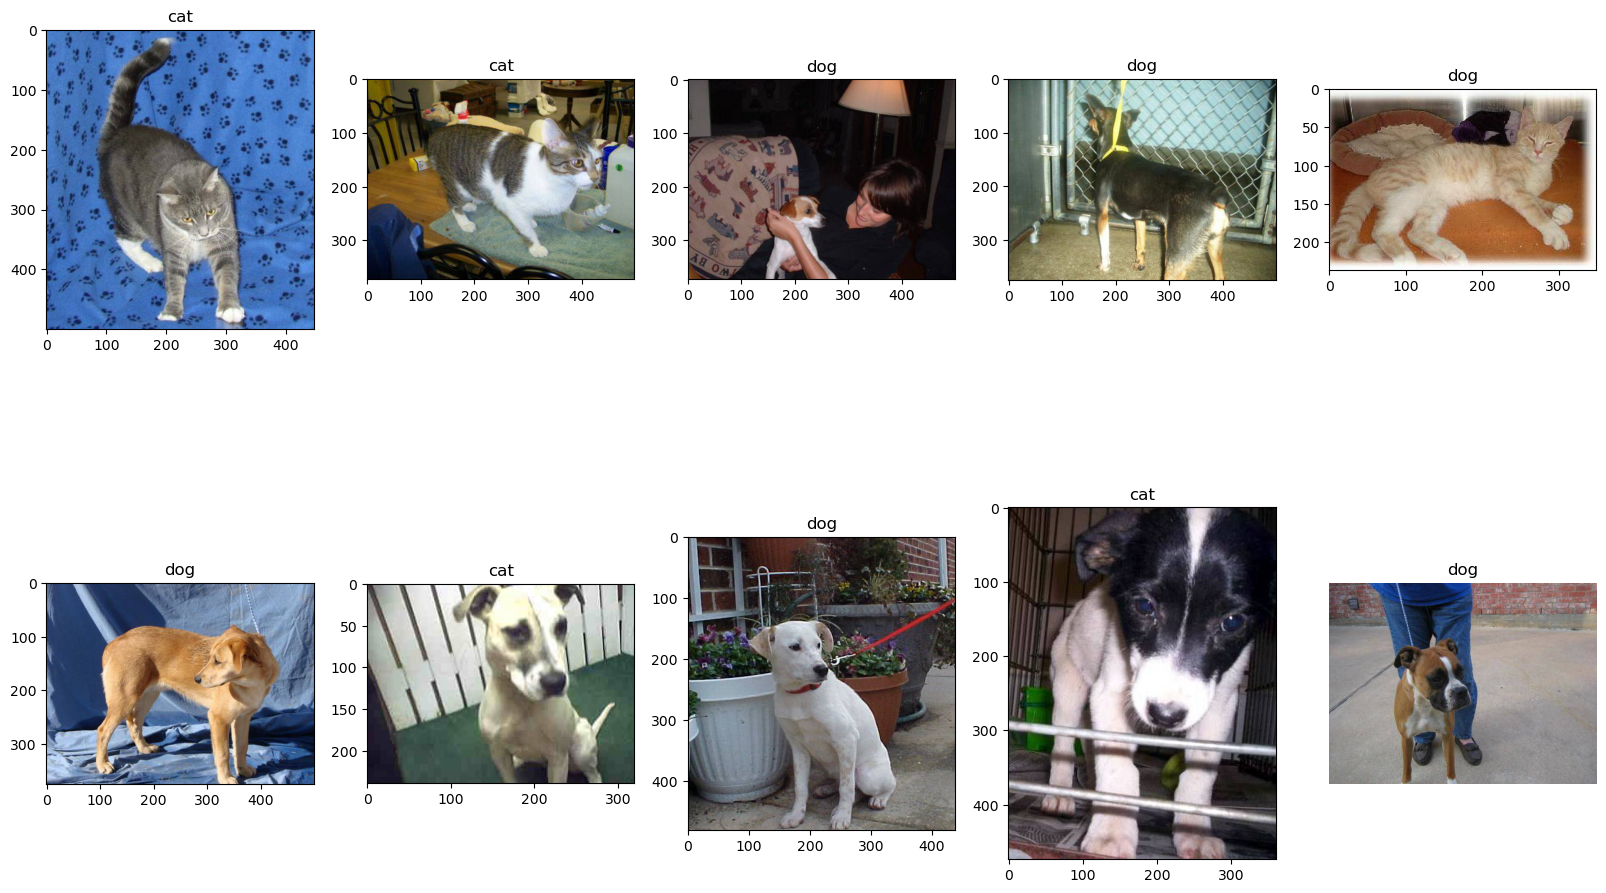

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

# Load train and test data
test_dir = '/Users/peterstroessler/Documents/Projects/cats_and_dogs/catdog/test'
# Load the CSV file using pandas
data_frame = pd.read_csv('result2.csv')

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(data_frame['id'].values)
    label = data_frame.loc[data_frame['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)
plt.axis('off')
plt.show()